In [20]:
import os
import pandas as pd
import json
from datetime import datetime
import re

# Initialize empty dictionary
experiments_data = {}

base_paths = []
starting_data_strs = []
finishing_data_strs = [] # List for finishing times

current_time_str = datetime.now().strftime("%Y-%m%d-%H%M%S")
print("Current time string:", current_time_str)
# Base path
base_paths.append("test/inverted_pendulum/ERM/")
starting_data_strs.append('2025-0425-230000')
finishing_data_strs.append('2025-0426-230000') # Now


for base_path, starting_data_str, finishing_data_str in zip(base_paths, starting_data_strs, finishing_data_strs):
    starting_data = datetime.strptime(starting_data_str, "%Y-%m%d-%H%M%S")
    finishing_data = datetime.strptime(finishing_data_str, "%Y-%m%d-%H%M%S")
    # List all folders in the directory
    folders = [f for f in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, f))]

    print("Found folders:", folders)
    for folder in folders:
        try:
            # folder_datetime = datetime.strptime(folder, "%Y-%m%d-%H%M%S-%f")
            folder_datetime = datetime.strptime(folder, "%Y-%m%d-%H%M%S")
        except :
            try:
                folder_datetime = datetime.strptime(folder, "%Y-%m%d-%H%M%S-%f")
            except :
                print(f"Warning: Folder name {folder} is not in the expected datetime format.")
                continue

        # Now we have a valid datetime
        # if folder_datetime < starting_data or folder_datetime > finishing_data:
        # print(f"Folder datetime: {folder_datetime}, Starting data: {starting_data}, Finishing data: {finishing_data}")
        # print(folder_datetime >= starting_data , folder_datetime <= finishing_data)
        if folder_datetime >= starting_data and folder_datetime <= finishing_data:

            folder_path = os.path.join(base_path, folder)

            # Paths to the files
            losses_path = os.path.join(folder_path, "losses.csv")
            args_path = os.path.join(folder_path, "args.json")
            log_path = os.path.join(folder_path, "logs", "log.txt")

            # Initialize dict for this experiment
            experiments_data[folder] = {}

            # Load losses.csv
            if os.path.exists(losses_path):
                experiments_data[folder]['losses'] = pd.read_csv(losses_path)
            else:
                print(f"Warning: {losses_path} not found.")

            # Load args.json
            if os.path.exists(args_path):
                with open(args_path, 'r') as f:
                    experiments_data[folder]['args'] = json.load(f)
            else:
                print(f"Warning: {args_path} not found.")

            # Load Lipschitz constant from log.txt
            if os.path.exists(log_path):
                with open(log_path, 'r') as f:
                    log_content = f.read()
                    match = re.search(r"Lipschitz constant: ([\d\.]+)", log_content)
                    if match:
                        experiments_data[folder]['lipschitz_constant'] = float(match.group(1))
                    else:
                        print(f"Warning: Lipschitz constant not found in {log_path}.")
            else:
                print(f"Warning: {log_path} not found.")

    # Now `experiments_data` has all the information loaded!

# Example: Print the keys loaded
print("Loaded experiment data for:", list(experiments_data.keys()))
print("Loaded experiment data for:", len(experiments_data.keys()))





Current time string: 2025-0429-162035
Found folders: ['2025-0426-001559', '2025-0425-200417', '2025-0425-181043', '2025-0425-231755', '2025-0428-181745-881113', '2025-0428-200056-956119', '2025-0425-180902', '2025-0426-185432', '2025-0428-164619-568699', '2025-0425-193043', '2025-0426-112805', '2025-0426-131030', '2025-0428-215617-840526', '2025-0425-180939', '2025-0426-114418', '2025-0425-185808', '2025-0428-180715-999266', '2025-0426-105536', '2025-0426-123540', '2025-0428-164644-846302', '2025-0425-212400', '2025-0425-175227', '2025-0425-191431', '2025-0428-213926-841744', '2025-0425-180826', '2025-0426-111209', '2025-0428-194320-784608', '2025-0426-134030', '2025-0425-221045', '2025-0425-203431', '2025-0426-110423', '2025-0426-121349']
Loaded experiment data for: ['2025-0426-001559', '2025-0425-231755', '2025-0426-185432', '2025-0426-112805', '2025-0426-131030', '2025-0426-114418', '2025-0426-105536', '2025-0426-123540', '2025-0426-111209', '2025-0426-134030', '2025-0426-110423', '

['2025-0426-001559', '2025-0425-231755', '2025-0426-185432', '2025-0426-112805', '2025-0426-131030', '2025-0426-114418', '2025-0426-105536', '2025-0426-123540', '2025-0426-111209', '2025-0426-134030', '2025-0426-110423', '2025-0426-121349']
Ready to compute Laplacian of size torch.Size([600, 4])
Completed Laplacian
2025-0426-001559
Lipschitz constant: 87.61565399169922, n_train: 20
2025-0425-231755
Lipschitz constant: 88.41624450683594, n_train: 18
2025-0426-185432
Lipschitz constant: 73.80873107910156, n_train: 4
2025-0426-112805
Lipschitz constant: 87.0344467163086, n_train: 10
2025-0426-131030
Lipschitz constant: 92.79696655273438, n_train: 18
2025-0426-114418
Lipschitz constant: 88.76589965820312, n_train: 12
2025-0426-105536
Lipschitz constant: 73.80873107910156, n_train: 2
2025-0426-123540
Lipschitz constant: 92.10592651367188, n_train: 16
2025-0426-111209
Lipschitz constant: 89.98979187011719, n_train: 8
2025-0426-134030
Lipschitz constant: 84.04370880126953, n_train: 20
2025-04

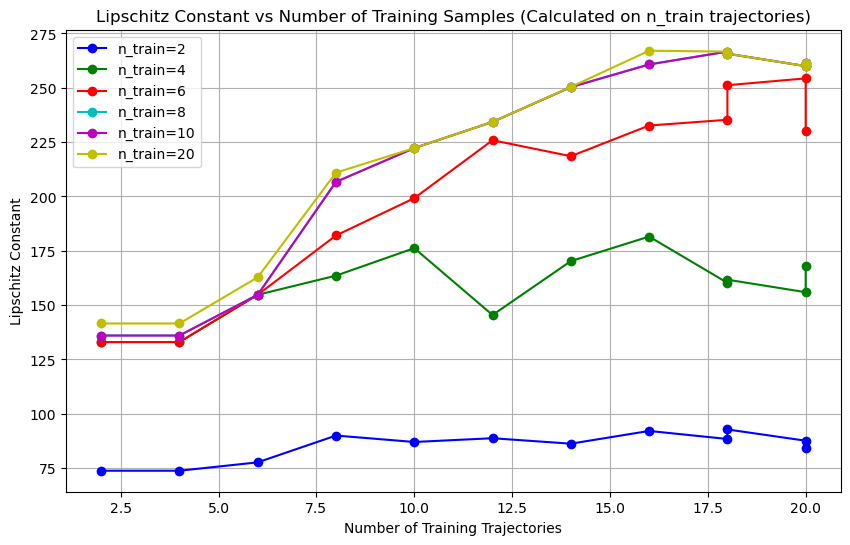

In [41]:
import smooth.lib.imitation as imitation
import smooth.scripts.imitation_learning as imitation_learning
from smooth import laplacian
from torch.utils.data import Dataset, DataLoader
import torch
from smooth.scripts.imitation_learning_model_loader import load_model
import matplotlib.pyplot as plt

exps = list(experiments_data.keys())
print (exps)
n_train = 10
plt.figure(figsize=(10, 6))
clr = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
for idx, n_train in enumerate([2, 4, 6, 8,  10, 20]):
    n_unlab, n_test, trajectory_length, bs = 0, 2, 300, 128 
    k, heat_kernel_t = 10, 1e-2
    data = imitation.create_imitation_dataset_trajectories('inverted_pendulum',
                                                n_train=n_train,
                                                n_unlab=n_unlab,
                                                n_test=n_test,
                                                T=trajectory_length)
    X_train, Y_train, X_unlab, y_unlab, X_test, Y_test = data

    train_dataset = imitation_learning.RegressionDataset(X_train, Y_train)
    test_dataset = imitation_learning.RegressionDataset(X_test, Y_test)
    train_loader = imitation_learning.DataLoader(train_dataset, batch_size=bs, shuffle=True)
    test_loader = imitation_learning.DataLoader(test_dataset, batch_size=bs)


    if X_unlab is not None:
        X_total = torch.concatenate((X_train, X_unlab), axis=0)
    else:
        X_total = X_train
    print('Ready to compute Laplacian of size', X_total.shape)
    adj_matrix = laplacian.get_pairwise_distance_matrix(X_total, t=heat_kernel_t, distance_type='euclidean')
        # L = laplacian.get_laplacian(X_total, args.normalize, heat_kernel_t=args.heat_kernel_t, clamp_value = args.clamp).to(device)
    matrix = laplacian.get_knn_matrix(X_total,  distance_type = 'euclidean', matrix_type = 'knn', k=k, batch_size=200)


    dataset = imitation_learning.NodeNeighborhoodDataset(matrix, X_total)
    unlabeled_loader_finite = DataLoader(dataset, batch_size=bs//k, shuffle=True, collate_fn=imitation_learning.collate_fn)
    print('Completed Laplacian')
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    base_paths = "test/inverted_pendulum/ERM/"
    n_trains = [] 
    lips = []
    for exp in exps:
        print(exp)
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        model_path = os.path.join(base_paths, exp, f'final_model.pth')
        # model_path = 'final_model.pth'
        model = load_model(imitation_learning.FCNN3, model_path, device)

        lipschitz_constant = imitation_learning.get_lipschitz_constant(model, unlabeled_loader_finite)  # Compute Lipschitz constant for logging
        this_n_train = experiments_data[exp]['args']['n_train']
        print(f'Lipschitz constant: {lipschitz_constant}, n_train: { this_n_train }')
        n_trains.append(this_n_train)
        lips.append(lipschitz_constant)

    # 1. Combine the lists into pairs
    combined = list(zip(n_trains, lips))

    # 2. Sort the pairs based on the first element (n_trains)
    combined_sorted = sorted(combined, key=lambda pair: pair[0])

    # 3. Unzip the sorted pairs back into separate lists
    n_trains_sorted, lips_sorted = zip(*combined_sorted)

    
    plt.plot(n_trains_sorted, lips_sorted, 'o-', color=clr[idx], label=f'n_train={n_train}')
plt.legend()
    
plt.title('Lipschitz Constant vs Number of Training Samples (Calculated on n_train trajectories)')
plt.xlabel('Number of Training Trajectories')
plt.ylabel('Lipschitz Constant')
plt.grid(True)
plt.show()